In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler


STATE = 42

np.random.seed(STATE)
tf.random.set_seed(STATE)

In [2]:
def disp_cf_results(cf):
    """Display counterfactual results nicely."""
    for feature, change in zip(features, cf['delta']):
        if change != 0:
            print(feature, change)

In [3]:
# Load data
dataset = load_breast_cancer() 
X, y = dataset['data'], dataset['target']
features = dataset['feature_names']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=STATE)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## CEML
https://github.com/andreArtelt/ceml

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [4]:
from ceml.backend.tensorflow.costfunctions import NegLogLikelihoodCost
from ceml.model import ModelWithLoss


class Model(ModelWithLoss):
    def __init__(self, X):
        super(Model, self).__init__()

        self.model = keras.models.Sequential([
            keras.layers.Input(shape=[X.shape[1],]),
            keras.layers.Dense(16, activation='selu'),
            keras.layers.Dense(8, activation='selu'),
            keras.layers.Dense(2, activation='softmax'),
        ])
    
    def fit(self, X_train, y_train, X_test, y_test, num_epochs=100):
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                           metrics=['accuracy'])

        self.model.fit(X_train, y_train, epochs=num_epochs, verbose=False,
                       validation_data=(X_test, y_test))

    def predict(self, x):
        return np.argmax(self.model(x), axis=1)
    
    def predict_proba(self, x):
        return self.model(x)
    
    def __call__(self, x):
        return self.predict(x)

    def get_loss(self, y_target, pred=None):
        return NegLogLikelihoodCost(input_to_output=self.model.predict_proba, y_target=y_target)

In [5]:
nn = Model(X_train)
nn.fit(X_train, y_train, X_test, y_test)

y_pred = nn.predict(X_test)
print("Model accuracy: {0}".format(accuracy_score(y_test, y_pred)))

Model accuracy: 0.9787234042553191


In [ ]:
from ceml.tfkeras import generate_counterfactual

# Select data point for explaining its prediction
x = X_test[1,:]
instance_pred = nn.predict(np.array([x]))[0]
print("Prediction on x: {0}".format(instance_pred))

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1.0)    # Init optimization algorithm
optimizer_args = {"max_iter": 1000}

# Compute counterfactual
cf = generate_counterfactual(
    nn, 
    x, 
    y_target=(1-instance_pred), 
    features_whitelist=None,
    regularization="l1", 
    C=0.01, 
    optimizer=optimizer, 
    optimizer_args=optimizer_args
)
disp_cf_results(cf)

## Scikit-Learn model 

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from ceml.sklearn import generate_counterfactual

# Whitelist of features - list of features we can change/use when computing a counterfactual 
features_whitelist = None   # We can use all features

# Create model
model = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=STATE)

# Fit model
model.fit(X_train, y_train)
print('Model accuracy = ', model.score(X_test, y_test))

# Select data point for explaining its prediction
x = X_test[0,:]
instance_pred = model.predict([x])[0]
print("Prediction on x: {0}".format(instance_pred))

# Compute counterfactual
cf = generate_counterfactual(model, x, y_target=(1-instance_pred), 
                             features_whitelist=features_whitelist)

disp_cf_results(cf)

Model accuracy =  0.9308510638297872
Prediction on x: 1


/Users/Nicholas/.pyenv/versions/3.7.8/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


radius error -0.08150556954896002
worst concavity 0.006817608746416126


### Timing Random Forest Model

In [8]:
import time

x = X_test[0,:]
instance_pred = model.predict([x])[0]

results = []

for n_estimators in [3, 5, 10, 20, 25, 30, 40]:
    # create and fit RF
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=3, 
                                random_state=STATE)
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    
    s = time.time()
    try:
        # try gen cf
        cf = generate_counterfactual(rf, x, y_target=(1-instance_pred), 
                                     features_whitelist=None)
        cf_found = True
    except Exception as e:
        print(e)
        cf_found = False
    time_elapsed = time.time() - s
    
    results.append([n_estimators, score, cf_found, time_elapsed])

results

No counterfactual found - Consider changing parameters 'C', 'regularization', 'features_whitelist', 'optimizer' and try again
No counterfactual found - Consider changing parameters 'C', 'regularization', 'features_whitelist', 'optimizer' and try again
No counterfactual found - Consider changing parameters 'C', 'regularization', 'features_whitelist', 'optimizer' and try again
No counterfactual found - Consider changing parameters 'C', 'regularization', 'features_whitelist', 'optimizer' and try again


[[3, 0.9308510638297872, True, 5.0919108390808105],
 [5, 0.9361702127659575, True, 16.53546690940857],
 [10, 0.9202127659574468, True, 19.168144941329956],
 [20, 0.9414893617021277, False, 255.7807731628418],
 [25, 0.9468085106382979, False, 357.21237993240356],
 [30, 0.9574468085106383, False, 529.0565738677979],
 [40, 0.9414893617021277, False, 1451.4815938472748]]

In [6]:
results = [
 [3, 0.9308510638297872, True, 5.0919108390808105],
 [5, 0.9361702127659575, True, 16.53546690940857],
 [10, 0.9202127659574468, True, 19.168144941329956],
 [20, 0.9414893617021277, False, 255.7807731628418],
 [25, 0.9468085106382979, False, 357.21237993240356],
 [30, 0.9574468085106383, False, 529.0565738677979],
 [40, 0.9414893617021277, False, 1451.4815938472748]
]

In [7]:
df = pd.DataFrame(results, columns=['n_estimators', 'accuracy', 'found_cf', 'compute_time'])
df

,n_estimators,accuracy,found_cf,compute_time
0,3,0.930851,True,5.091911
1,5,0.936170,True,16.535467
2,10,0.920213,True,19.168145
3,20,0.941489,False,255.780773
4,25,0.946809,False,357.212380
5,30,0.957447,False,529.056574
6,40,0.941489,False,1451.481594


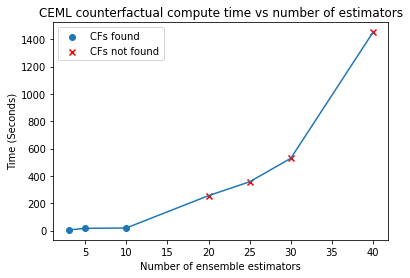

In [20]:
import matplotlib.pyplot as plt

plt.plot(df['n_estimators'], df['compute_time'])
plt.scatter(df['n_estimators'].iloc[:3], df['compute_time'].iloc[:3], marker='o', label='CFs found')
plt.scatter(df['n_estimators'].iloc[3:], df['compute_time'].iloc[3:], marker='x', color='red', 
            label='CFs not found')
plt.title('CEML counterfactual compute time vs number of estimators')
plt.xlabel('Number of ensemble estimators')
plt.ylabel('Time (Seconds)')
plt.legend()
plt.savefig('rf-ceml-results.pdf')